See notebook in Google Colab : https://drive.google.com/drive/folders/1RX0o4puey7lUXwwYv-NMwMdyIfOypRN5?usp=share_link

# Credit Risk Sensitivity to Carbon Price Project

This project is based on [Bouchet/Le Guenedal, 2020](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3574486) and it reproduces the results of the working paper. The data is taken from https://data.ene.iiasa.ac.at/iamc-1.5c-explorer/#/workspaces. Then, the physical risk is modelised in Merton's model by adding a Poisson component in the diffusion, characterized by stochastic equation from Black & Scholes model.

In [17]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [18]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Projects_for_Github/Credit_Risk_Sensitivity_to_Carbon_Price/'
import numpy as np
from scipy.stats import norm, poisson
import pandas as pd
import matplotlib.pyplot as plt
from random import gauss
import math

In [19]:
!pip install --upgrade openpyxl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
# Load dataframe using pandas
df = pd.read_excel(file_path + 'iamc15_scenario_data_all_regions_r2.0.xlsx', sheet_name = 'data')

## Data preparation
The data is filtered to reproduce the conditions of the paper. The model is MESSAGE_GLOBIOM 1.0 and the scenarios are SSP2-19, SSP2-26 and SSP2-34, which respectively correspond to an elevation of 1.5°C, 1.7 °C and 2.2°C of the mean temperature by 2100.

In [21]:
# Filter on the model
is_MESSAGEGLOBIOM = df['Model'] == 'MESSAGE-GLOBIOM 1.0' # Filter on model considered in the article
df1 = df[is_MESSAGEGLOBIOM]

# Filter on the region
def filter_region(df=df1, Region='World') : # Filter on Region
  '''
  Parameters :
    - df : pandas Dataframe containing data
    - Region : Region of the world
  Output : 
    A pandas dataframe filtered on the selected region
  Description :
    Function which select a region from the list and filter the dataframe on it
  '''
  is_Region = df['Region'] == Region
  return df[is_Region]

# Filter dataframe on Region
df2 = filter_region()

# Compute times list
times = [int(column) for column in df.columns if column[-2:] in [str(i) for i in range(10,120,10)]] + [2005,2100]
cols_not_to_drop = [str(i) for i in times]
times.sort()

# Select columns in the dataframe we want to drop, which are columns where no or too few data is present (we only keep years 10 by 10)
cols_to_drop = [column for column in df.columns if column not in (cols_not_to_drop+['Model','Scenario','Region','Variable','Unit'])] 
df3 = df2.drop(columns=cols_to_drop)

# Filter on the scenario and return the final C02 emissions and prices
scenarios = ['SSP2-19', 'SSP2-26', 'SSP2-34', 'SSP2-Baseline']
def filter_on_scenario(df=df3, i=0, scenarios=scenarios) :
  '''
  Parameters :
    - df : pandas Dataframe containing data
    - scenarios : list of scenarios
    - i : index of sector in the list of scenarios, integer between 0 and len(scenarios)
  Output : 
    A pandas dataframe filtered on the selected scenario
  Description :
    Function which select a scenario from the list and filter the dataframe on it
  '''
  is_Scenario = df['Scenario'] == scenarios[i]
  return df[is_Scenario]

df4 = filter_on_scenario()

# Booleans to filter on Prices or CO2 Emissions, depending on the sector
sectors = ['Emissions|CO2', 'Emissions|CO2|AFOLU', 'Emissions|CO2|Energy and Industrial Processes', 'Emissions|CO2|Energy|Demand|Industry', 'Emissions|CO2|Energy|Demand|Residential and Commercial', 'Emissions|CO2|Energy|Supply|Electricity']
def filter_on_sector(df=df4, i=0, sectors=sectors) :
  '''
  Parameters :
    - df : pandas Dataframe containing data
    - sectors : list of sectors
    - i : index of sector in the list of sectors, integer between 0 and len(sectors)
  Output : 
    A pandas dataframe filtered on the selected sector
  Description :
    Function which select a sector from the list and filter the dataframe on it
  '''
  is_CO2 = df['Variable'] == sectors[i]
  return df[is_CO2]

# Compute boolean to filter variable on Price
is_price = df4['Variable'] == 'Price|Carbon'


df_CO2_raw, df_price_raw = filter_on_sector(), df4[is_price]

df_CO2, df_price = df_CO2_raw.drop([e for e in df.columns if not e.isdigit()], axis=1), df_price_raw.drop([e for e in df.columns if not e.isdigit()], axis=1)

CO2, prices = df_CO2.to_numpy(dtype=float)[0], df_price.to_numpy(dtype=float)[0]

## Probability of Default

In [22]:
carbon_cost = np.multiply(CO2, prices) # If we consider world values, so we do not need to sum over the regions
T = 1. # Time horizon
V0 = 10*max(carbon_cost) # Total asset value
D0 = V0 # Amount of debt
sigma_V = 0.2 # Total asset volatility
r = 0.05 # Risk-free rate

### Article's model
In [Bouchet/Le Guenedal, 2020](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3574486), the asset values are computed using

$$V(i,k,t) = (1 - \xi (i,k,t)) \times V(i,k=0,t=0)$$

where _beta_ is the shock to EBITDA 

In [23]:
EBITDA0 = sum(carbon_cost) # Earnings before interest, taxes, depreciation, and amortization

In [24]:
PD_article = []
D = D0
for i in range(len(carbon_cost)) :
  #####################
  shock_to_EBITDA = carbon_cost[i]/EBITDA0 # Shock
  V = (1-shock_to_EBITDA)*V0 # Total asset values
  #####################
  d1 = (np.log(V/D) + (r+1/2*sigma_V**2))*T/(sigma_V*np.sqrt(T))
  d2 = d1 - sigma_V*np.sqrt(T)
  D = D0*np.exp(-r*T)*norm.cdf(d2) + V*norm.cdf(-d1) # Debt
  #E = V*norm.cdf(d1) - D*np.exp(-r*T)*norm.cdf(d2) # Equity
  DD = (np.log(V/D) + (r+1/2*(sigma_V)**2))*T/(sigma_V*np.sqrt(T)) # Distance to Default
  PD_article.append(norm.cdf(-DD)) # Probability of Default

### Merton's model
We use Merton's model for the computation of the probability of default.

$$ \frac{dV_{t}}{V_{t}} = rdt + \sigma dW_{t}$$
where $W_{t}$ is a brownian motion under the risk-neutral probability.

In [25]:
G = gauss(0.0, 1.0)

In [26]:
PD_merton = []
D = D0
V = V0
for i in range(len(carbon_cost)) :
  #####################
  V = V*np.exp((r+1/2*sigma_V**2)*T+sigma_V*np.sqrt(T)*G) # Total asset values
  #####################
  d1 = (np.log(V/D) + (r+1/2*sigma_V**2))*T/(sigma_V*np.sqrt(T))
  d2 = d1 - sigma_V*np.sqrt(T)
  D = D0*np.exp(-r*T)*norm.cdf(d2) + V*norm.cdf(-d1) # Debt
  #E = V*norm.cdf(d1) - D*np.exp(-r*T)*norm.cdf(d2) # Equity
  DD = (np.log(V/D) + (r+1/2*(sigma_V)**2))*T/(sigma_V*np.sqrt(T)) # Distance to Default
  PD_merton.append(norm.cdf(-DD)) # Probability of Default

### Merton's model with Poisson component
We use Merton's model for the computation of the probability of default and we model physical risk by adding a Poisson component.

$$V_{t}=V_{0}exp((r+\gamma\lambda+\frac{\sigma^2}{2})t+\sigma W_{t}+N_{t}ln(1-\gamma))$$

In [27]:
G = gauss(0.0, 1.0)
# Poisson
Lambda = 4 # Poisson parameter
gamma = 0.1 #Fraction of assets value lost at each climate events

In [28]:
PD_merton_poisson = []
D = D0
V = V0
for i in range(len(carbon_cost)) :
  #####################
  poisson_prob = poisson.pmf(i,Lambda)
  N = 1 if poisson_prob > .5 else 0 # Number of events occured
  V = V*(1-gamma)*np.exp((r+Lambda*gamma+1/2*sigma_V**2)*sigma_V*np.sqrt(T)*G) # Poisson
  ##################### 
  d1 = (np.log(V/D) + (r+1/2*sigma_V**2))*T/(sigma_V*np.sqrt(T))
  d2 = d1 - sigma_V*np.sqrt(T)
  D = D0*np.exp(-r*T)*norm.cdf(d2) + V*norm.cdf(-d1) # Debt
  #E = V*norm.cdf(d1) - D*np.exp(-r*T)*norm.cdf(d2) # Equity
  DD = (np.log(V/D) + (r+1/2*(sigma_V)**2))*T/(sigma_V*np.sqrt(T)) # Distance to Default
  PD_merton_poisson.append(norm.cdf(-DD)) # Probability of Default

## Plots

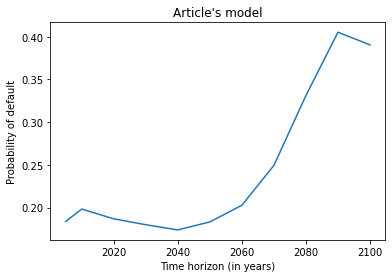

In [29]:
plt.xlabel('Time horizon (in years)')
plt.ylabel('Probability of default')
plt.title("Article's model")
plt.plot(times,PD_article)
plt.savefig("Article's model.svg",format="svg")
plt.show()

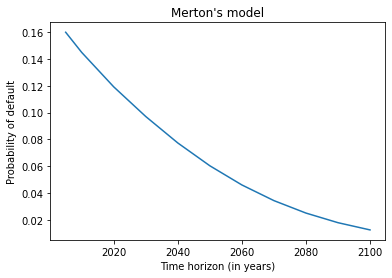

In [30]:
plt.xlabel('Time horizon (in years)')
plt.ylabel('Probability of default')
plt.title("Merton's model")
plt.plot(times,PD_merton)
plt.savefig("Merton's model.svg",format="svg")
plt.show()

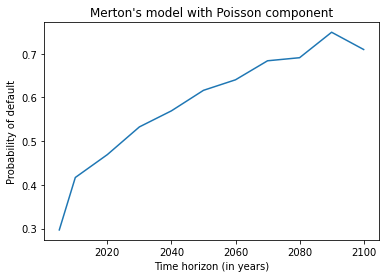

In [31]:
plt.xlabel('Time horizon (in years)')
plt.ylabel('Probability of default')
plt.title("Merton's model with Poisson component")
plt.plot(times,PD_merton_poisson)
plt.savefig("Merton's model with Poisson component.svg",format="svg")
plt.show()

### Download plots

In [32]:
# files.download("Article's model.svg")
# files.download("Merton's model.svg")
# files.download("Merton's model with Poisson component.svg")